In [3]:

import cv2

In [ ]:
#!/bin/python3

import math
import os
import random
import re
import sys



#
# Complete the 'flippingMatrix' function below.
#
# The function is expected to return an INTEGER.
# The function accepts 2D_INTEGER_ARRAY matrix as parameter.
#

def flippingMatrix(matrix):
    # Write your code here
    value=0
    len_iter=int(len(matrix)/2)
    for i in range(len_iter):
        for j in range(len_iter):
            cur=matrix[i][j]
            dig=matrix[len(matrix)-1-i][len(matrix)-1-j]
            right=matrix[i][len(matrix)-1-j]
            left=matrix[len(matrix)-1-i][j]
            matrix[i][j]=max(cur,dig,right,left)
            value+=matrix[i][j]
    return value
if __name__ == '__main__':
    fptr = open(os.environ['OUTPUT_PATH'], 'w')

    q = int(input().strip())

    for q_itr in range(q):
        n = int(input().strip())

        matrix = []

        for _ in range(2 * n):
            matrix.append(list(map(int, input().rstrip().split())))

        result = flippingMatrix(matrix)

        fptr.write(str(result) + '\n')

    fptr.close()


In [4]:
img = cv2.imread('dataset/png_masks/MASKS/seg_0001.png')
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [11]:
# import shutil
# import random
# import os
#
# all_img = os.listdir('dataset/jpeg_images/IMAGES')
# test_img = random.sample(all_img, 180)
# train_img = [im for im in all_img if im not in test_img]
# for img_name in all_img:
#     if img_name in train_img:
#         shutil.copy('dataset/jpeg_images/IMAGES/' + img_name, 'dataset/train/images/' + img_name)
#         shutil.copy('dataset/png_masks/MASKS/' + 'seg_' + img_name.split('.')[0].split('_')[1] + '.png',
#                     'dataset/train/masks/' + 'seg_' + img_name.split('.')[0].split('_')[1] + '.png')
#     else:
#         shutil.copy('dataset/jpeg_images/IMAGES/' + img_name, 'dataset/valid/images/' + img_name)
#         shutil.copy('dataset/png_masks/MASKS/' + 'seg_' + img_name.split('.')[0].split('_')[1] + '.png',
#                     'dataset/valid/masks/' + 'seg_' + img_name.split('.')[0].split('_')[1] + '.png')


In [6]:
img.shape

(825, 550, 3)

In [2]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as aug

In [3]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "valid"
        self.img_dir = os.path.join(self.root_dir, sub_path, 'images')
        self.ann_dir = os.path.join(self.root_dir, sub_path, 'masks')

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)

        #         image = Image.open()
        #         segmentation_map = Image.open()

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k, v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()  # remove batch dimension
        return encoded_inputs

In [4]:
root_dir = 'dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None,
                                         train=False)

In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 820
Number of validation examples: 180


In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs

{'pixel_values': tensor([[[0.2282, 0.2282, 0.2453,  ..., 0.6734, 0.6563, 0.5878],
         [0.8961, 0.7591, 0.5536,  ..., 0.4679, 0.4337, 0.3994],
         [1.2899, 1.1872, 1.0502,  ..., 0.2282, 0.2282, 0.2111],
         ...,
         [0.5193, 0.4508, 0.3823,  ..., 0.7419, 0.7762, 0.6906],
         [0.3138, 0.4337, 0.3994,  ..., 0.6392, 0.7248, 0.7762],
         [0.1083, 0.2624, 0.2967,  ..., 0.8104, 0.8104, 0.7762]],

        [[0.5378, 0.5378, 0.5553,  ..., 0.9230, 0.9055, 0.8354],
         [1.2206, 1.0805, 0.8704,  ..., 0.7304, 0.6954, 0.6429],
         [1.6232, 1.5182, 1.3782,  ..., 0.4678, 0.4503, 0.4503],
         ...,
         [0.6078, 0.5378, 0.4678,  ..., 0.8179, 0.8529, 0.7654],
         [0.3978, 0.5203, 0.4853,  ..., 0.7129, 0.8004, 0.8529],
         [0.1877, 0.3452, 0.3803,  ..., 0.8880, 0.8880, 0.8529]],

        [[0.9319, 0.9319, 0.9494,  ..., 1.3502, 1.3328, 1.2631],
         [1.6117, 1.4722, 1.2631,  ..., 1.1411, 1.0888, 1.0539],
         [2.0125, 1.9080, 1.7685,  ..., 0

In [9]:
mask = encoded_inputs["labels"].numpy()
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
np.unique(encoded_inputs["labels"].numpy())

array([ 0, 14, 19, 24, 32, 41, 44])

In [11]:
import matplotlib.pyplot as plt

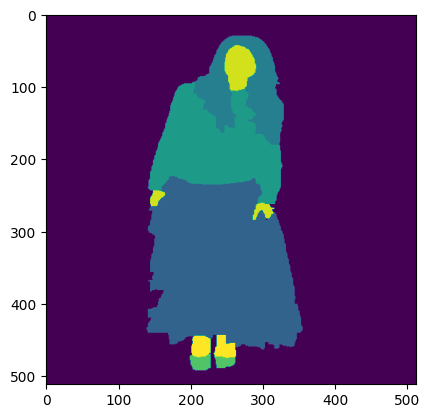

In [12]:
plt.imshow(mask)

In [6]:
classes = pd.read_csv('dataset/labels.csv')['label_list']
id2label = classes.to_dict()
id2label[0] = 'back_ground'
id2label

{0: 'back_ground',
 1: 'accessories',
 2: 'bag',
 3: 'belt',
 4: 'blazer',
 5: 'blouse',
 6: 'bodysuit',
 7: 'boots',
 8: 'bra',
 9: 'bracelet',
 10: 'cape',
 11: 'cardigan',
 12: 'clogs',
 13: 'coat',
 14: 'dress',
 15: 'earrings',
 16: 'flats',
 17: 'glasses',
 18: 'gloves',
 19: 'hair',
 20: 'hat',
 21: 'heels',
 22: 'hoodie',
 23: 'intimate',
 24: 'jacket',
 25: 'jeans',
 26: 'jumper',
 27: 'leggings',
 28: 'loafers',
 29: 'necklace',
 30: 'panties',
 31: 'pants',
 32: 'pumps',
 33: 'purse',
 34: 'ring',
 35: 'romper',
 36: 'sandals',
 37: 'scarf',
 38: 'shirt',
 39: 'shoes',
 40: 'shorts',
 41: 'skin',
 42: 'skirt',
 43: 'sneakers',
 44: 'socks',
 45: 'stockings',
 46: 'suit',
 47: 'sunglasses',
 48: 'sweater',
 49: 'sweatshirt',
 50: 'swimwear',
 51: 't-shirt',
 52: 'tie',
 53: 'tights',
 54: 'top',
 55: 'vest',
 56: 'wallet',
 57: 'watch',
 58: 'wedges'}

In [7]:

label2id = {v: k for k, v in id2label.items()}

In [8]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_he

In [16]:
model.segformer.encoder.layer_norm

ModuleList(
  (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [9]:
optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/home/amirhossein/PycharmProjects/my_segementation_works/venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Initialized!


In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [12]:

for epoch in range(1, 11):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear",
                                                     align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 0)  # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix(
            {'Batch': idx, 'Pixel-wise accuracy': sum(accuracies) / len(accuracies), 'Loss': sum(losses) / len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear",
                                                             align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 0)  # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies) / len(accuracies)}\
         Train Loss: {sum(losses) / len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies) / len(val_accuracies)}\
         Val Loss: {sum(val_losses) / len(val_losses)}")

Epoch: 1


  0%|          | 0/205 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4396913620337033         Train Loss: 0.9954461199481313         Val Pixel-wise accuracy: 0.5131081651483848         Val Loss: 0.5145224319563971
Epoch: 2


  0%|          | 0/205 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5821610173742836         Train Loss: 0.39615297811787303         Val Pixel-wise accuracy: 0.6109029510038274         Val Loss: 0.38021702170372007
Epoch: 3


  0%|          | 0/205 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6689010664300661         Train Loss: 0.2946359933149524         Val Pixel-wise accuracy: 0.6439830652408536         Val Loss: 0.35057463314798143
Epoch: 4


  0%|          | 0/205 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7323254791787094         Train Loss: 0.23184411449403297         Val Pixel-wise accuracy: 0.6518653520626365         Val Loss: 0.3534144918123881
Epoch: 5


  0%|          | 0/205 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
!which python

/home/amirhossein/PycharmProjects/my_segementation_works/venv/bin/python


In [23]:
# torch.save(model.state_dict(), 'model_weights.pth')
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [24]:
PALETTE = np.array([[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
                    [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
                    [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
                    [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
                    [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
                    [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
                    [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
                    [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
                    [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
                    [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
                    [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
                    [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
                    [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
                    [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
                    [255, 71, 0], [0, 235, 255], [0, 173, 255]])

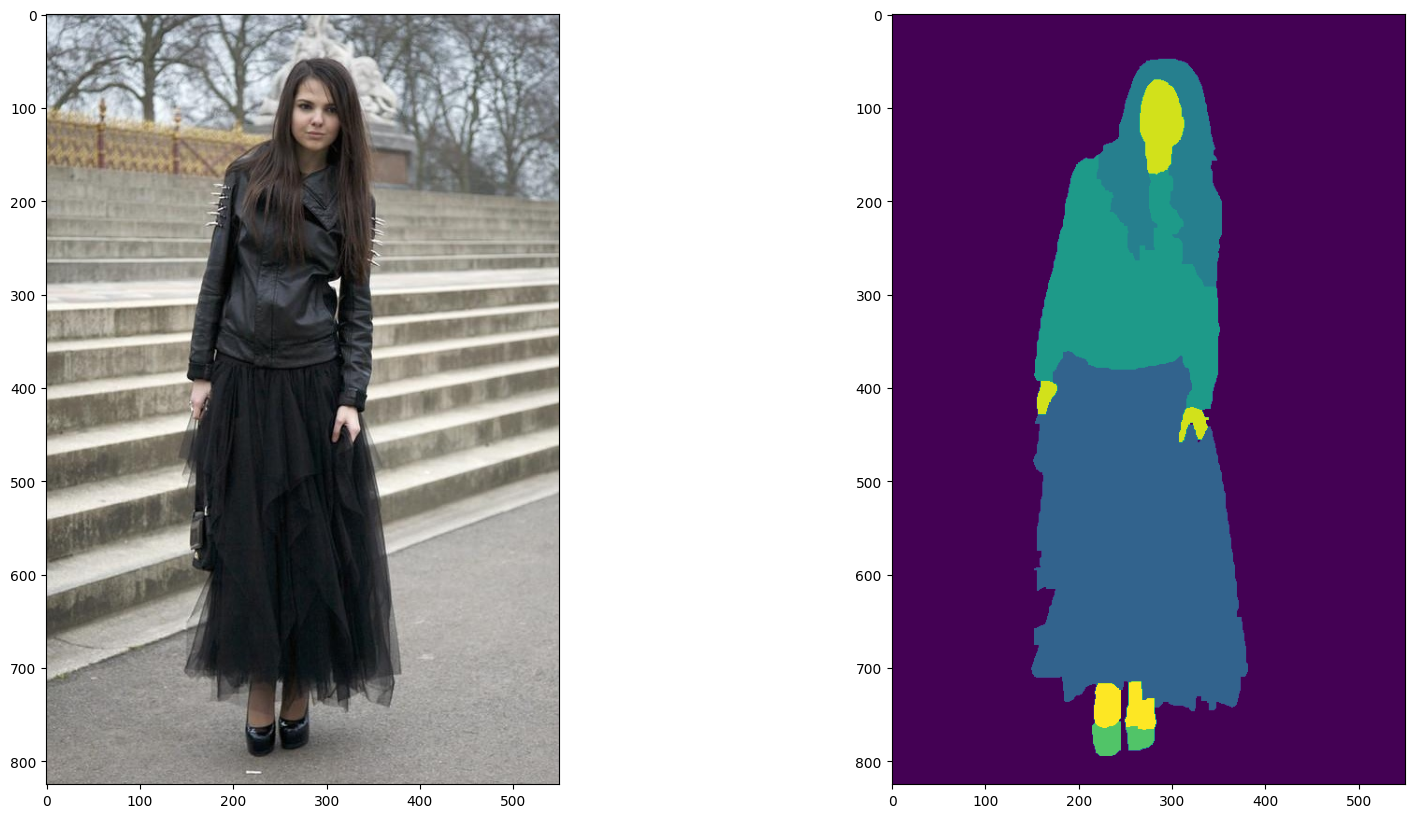

In [25]:
image = Image.open('dataset/train/images/img_0002.jpeg')
mask = Image.open('dataset/train/masks/seg_0002.png').convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [27]:
image.size

(550, 825)

In [28]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [29]:
model(pixel_values).logits.shape

torch.Size([1, 59, 128, 128])

In [30]:
model.eval()
outputs = model(pixel_values=pixel_values)  # logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 59, 128, 128])


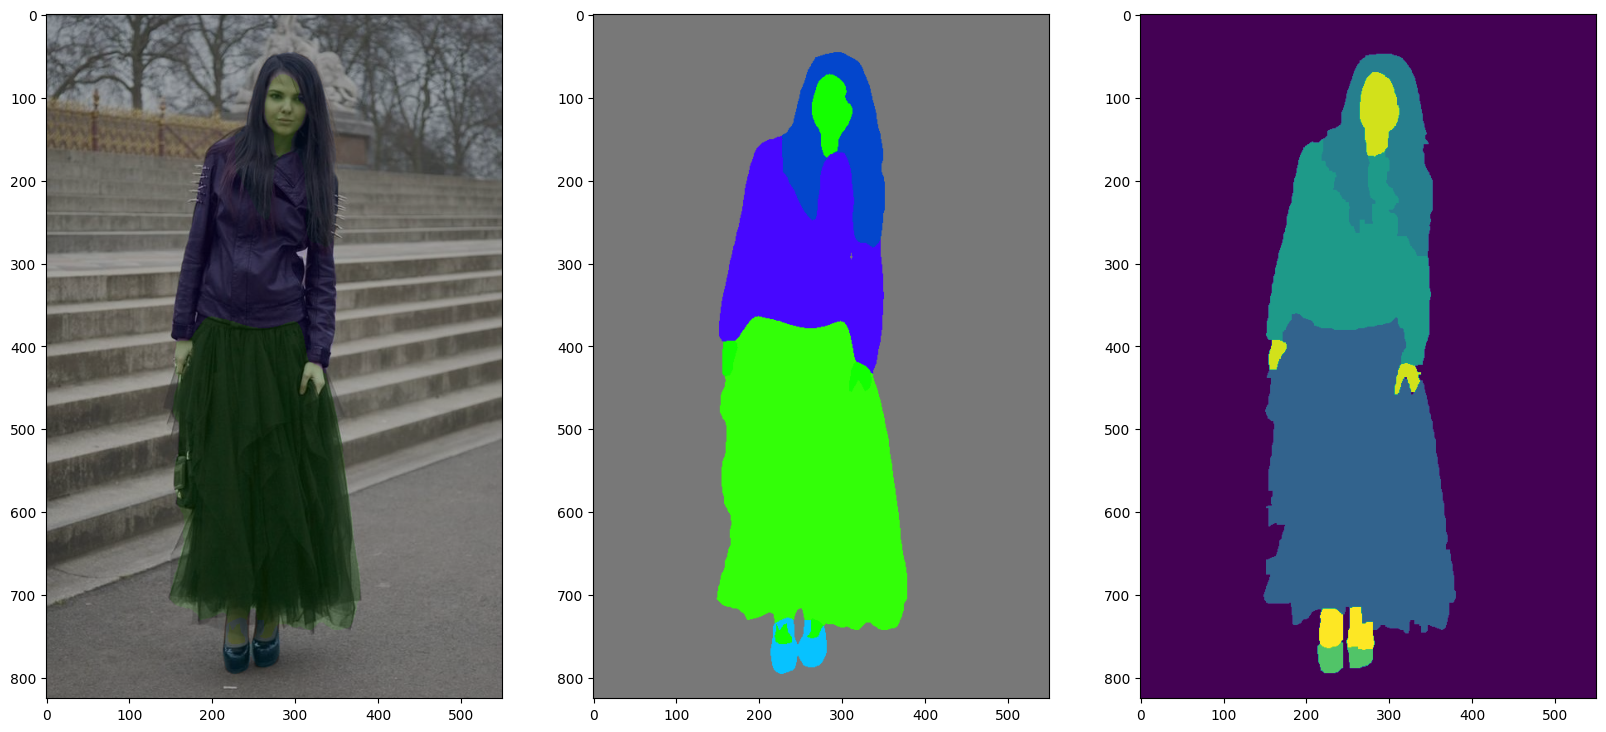

In [31]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                                             size=image.size[::-1],  # (height, width)
                                             mode='bilinear',
                                             align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)  # height, width, 3\
for label, color in enumerate(PALETTE):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.6 + color_seg * 0.1
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
axs[2].imshow(mask)
plt.show()

In [32]:
seg.shape

torch.Size([825, 550])

In [34]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [50]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        upsampled_logits = nn.functional.interpolate(self.model(x).logits,
                                             size=(512,512),  # (height, width)
                                             mode='bilinear',
                                             align_corners=False)
        return upsampled_logits
model = SegmentationModelOutputWrapper(model)

In [51]:
from pytorch_grad_cam import GradCAM


class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[14, :, :] * self.mask).sum()



alpha_mask = seg.numpy()
alpha_mask_uint8 = 255 * np.uint8(alpha_mask == 14)
alpha_mask_float = np.float32(alpha_mask == 14)
target_layers = [model.model.model.segformer.encoder.block[1][3].attention.self.sr]
targets = [SemanticSegmentationTarget(14, alpha_mask_float)]
image = np.array(Image.open('dataset/train/images/img_0002.jpeg'))
rgb_img = np.float32(image) / 255
input_tensor =feature_extractor_inference(Image.open('dataset/train/images/img_0002.jpeg'), return_tensors="pt").pixel_values
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)




AttributeError: 'Tensor' object has no attribute 'logits'

In [49]:
input_tensor.shape

torch.Size([1, 3, 512, 512])

In [48]:
model.model.segformer.encoder.block[1][3].attention.self.sr

Conv2d(128, 128, kernel_size=(4, 4), stride=(4, 4))

In [148]:
input_tensor

tensor([[[[0.0741, 0.1083, 0.1939,  ..., 0.7248, 0.6906, 0.6392],
          [0.4679, 0.3994, 0.3309,  ..., 0.6392, 0.5707, 0.5022],
          [0.9817, 0.8276, 0.6049,  ..., 0.4508, 0.4166, 0.3823],
          ...,
          [0.2624, 0.4679, 0.5022,  ..., 0.5707, 0.6906, 0.7762],
          [0.0569, 0.2967, 0.3652,  ..., 0.7419, 0.7933, 0.8276],
          [0.1083, 0.2282, 0.2796,  ..., 0.8789, 0.8104, 0.7419]],

         [[0.3803, 0.4153, 0.5028,  ..., 0.9755, 0.9405, 0.8880],
          [0.7829, 0.7129, 0.6429,  ..., 0.8880, 0.8179, 0.7479],
          [1.3081, 1.1506, 0.9230,  ..., 0.7129, 0.6779, 0.6429],
          ...,
          [0.3452, 0.5553, 0.5903,  ..., 0.6429, 0.7654, 0.8529],
          [0.1352, 0.3803, 0.4503,  ..., 0.8179, 0.8704, 0.9055],
          [0.1877, 0.3102, 0.3627,  ..., 0.9580, 0.8880, 0.8179]],

         [[0.7751, 0.8099, 0.8971,  ..., 1.4025, 1.3677, 1.3154],
          [1.1759, 1.1062, 1.0365,  ..., 1.3154, 1.2457, 1.1759],
          [1.6988, 1.5420, 1.3154,  ..., 1

In [144]:
model.model.model.model.segformer

SegformerModel(
  (encoder): SegformerEncoder(
    (patch_embeddings): ModuleList(
      (0): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (1): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (3): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (block): ModuleList(
      (0): ModuleList(
        (0): Segform

In [30]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits


model = SegmentationModelOutputWrapper(model)
model

SegmentationModelOutputWrapper(
  (model): SegmentationModelOutputWrapper(
    (model): SegmentationModelOutputWrapper(
      (model): SegformerForSemanticSegmentation(
        (segformer): SegformerModel(
          (encoder): SegformerEncoder(
            (patch_embeddings): ModuleList(
              (0): SegformerOverlapPatchEmbeddings(
                (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
                (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              )
              (1): SegformerOverlapPatchEmbeddings(
                (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              )
              (2): SegformerOverlapPatchEmbeddings(
                (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)


In [34]:
model.model.model.model.segformer

SegformerModel(
  (encoder): SegformerEncoder(
    (patch_embeddings): ModuleList(
      (0): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (1): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (3): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (block): ModuleList(
      (0): ModuleList(
        (0): Segform

In [50]:
np.uint8(seg.numpy() == 14)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        model.eval()
        with torch.no_grad():
            return self.model(x).logits

In [2]:
import torch

In [4]:
modell = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
modell


Using cache found in /home/amirhossein/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-16 Python-3.10.6 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16125MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [9]:
modell.model.model.model[-2]

C3(
  (cv1): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
  )
)